## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [90]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [91]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [92]:
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


c. The number of unique users in the dataset.

In [93]:
len(df.user_id.unique())

290584

d. The proportion of users converted.

In [94]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [95]:
df.landing_page.unique()
df.query('group == "treatment" and landing_page != "new_page"').user_id.count() + df.query('group == "control" and landing_page != "old_page"').user_id.count()

3893

f. Do any of the rows have missing values?

In [96]:
df[df.isnull().any(axis=1)].count()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [97]:
df2 = df.query('group=="treatment" and landing_page=="new_page"').append(df.query('group=="control" and landing_page=="old_page"'))
df2.describe()

,user_id,converted
count,290585.000000,290585.000000
mean,788004.825246,0.119597
std,91224.582639,0.324490
min,630000.000000,0.000000
25%,709035.000000,0.000000
50%,787995.000000,0.000000
75%,866956.000000,0.000000
max,945999.000000,1.000000


In [98]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [99]:
len(df2.user_id.unique())

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [100]:
df2.groupby('user_id').count().query('timestamp >1')

,timestamp,group,landing_page,converted
user_id,,,,
773192,2,2,2,2


c. What is the row information for the repeat **user_id**? 

In [101]:
df2.query('user_id==773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [102]:
df2 = df2.drop(1899, axis=0)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [103]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [104]:
df2.query('group=="control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [105]:
df2.query('group=="treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [106]:
df2.query('landing_page=="new_page"').user_id.count()/df2.user_id.count()

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

Answer: We don't seem to have sufficient evidence to suggest that new page is resulting in more conversions. Mean conversion for both control and treatment groups is close to 0.12. Overall conversion mean is also close to 0.12.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

Answer: Null Hypothesis: P(old) >= P(new)

Our null hypothesis is that the conversion rates for old page is same (or better than) as new page. If the alternative is true, we will reject null.

Alternative hypotheis: P(old) < P(new)

Alternative is that the conversion rate for new page is greater from old. We would want this to be true, rejecting the null.

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [107]:
diff = []
size_df2 = df2.shape[0]
for _ in range(10000):
    sample = df2.sample(size_df2, replace=True)
    nm = sample.query('landing_page == "new_page"')['converted'].mean()
    om = sample.query('landing_page == "old_page"')['converted'].mean()
    diff.append(nm-om)


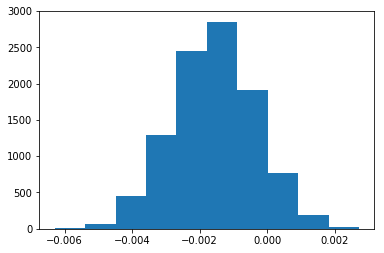

In [108]:
plt.hist(diff);

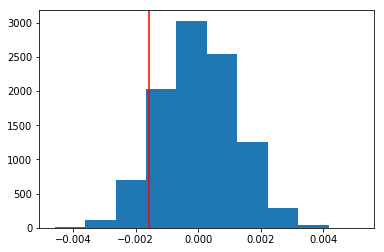

In [109]:
observed_diff = df2.query('landing_page=="new_page"').converted.mean()-df2.query('landing_page=="old_page"').converted.mean()
diff = np.array(diff)
sim_null = np.random.normal(0, diff.std(), diff.size)
plt.hist(sim_null);
plt.axvline(x=observed_diff,color='red')

a. What is the **convert rate** for $p_{new}$ under the null? 

In [110]:
df2.converted.mean()

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [111]:
df2.converted.mean()

0.11959708724499628

c. What is $n_{new}$?

In [112]:
nnew = df2.query('group=="treatment"').user_id.count()
nnew

145310

d. What is $n_{old}$?

In [113]:
df2.query('group=="control"').count()

user_id         145274
timestamp       145274
group           145274
landing_page    145274
converted       145274
dtype: int64

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [114]:
new_page_converted = np.random.choice([0, 1], size=nnew, p=[1-df2.converted.mean(), df2.converted.mean()])
new_page_converted.mean()

0.11851902828435758

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [115]:
old_page_converted = np.random.choice([0, 1], size=nnew, p=[1-df2.converted.mean(), df2.converted.mean()])
old_page_converted.mean()

0.12107219048929874

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [116]:
new_page_converted.mean()-old_page_converted.mean()

-0.002553162204941159

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [117]:
p_diffs = []

bias_rate = df2.converted.mean()

for _ in range(10000):
    new_page_sim = np.random.choice([0, 1], size=nnew, p=[1-bias_rate, bias_rate])
    old_page_sim = np.random.choice([0, 1], size=nnew, p=[1-bias_rate, bias_rate])
    p_diffs.append(new_page_sim.mean()-old_page_sim.mean())

p_diffs = np.array(p_diffs)


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

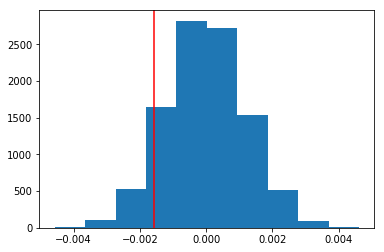

In [118]:
plt.hist(p_diffs);
plt.axvline(x=observed_diff,color='red')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [119]:
(p_diffs>observed_diff).mean()

0.9065

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

Answer: The p value is close to 0.9 which means that assumption under null hypothesis very likely to be correct and we can't reject null hypothesis. There is no difference between new and old pages as far as the conversion rate is concerned. Since, we can't reject null, new has conversion rate lower or same as old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [120]:
import statsmodels.api as sm


convert_old = df2.query('converted == 1 and landing_page == "old_page"').user_id.count()
convert_new = df2.query('converted == 1 and landing_page == "new_page"').user_id.count()
n_old = df2.query('landing_page == "old_page"').user_id.count()
n_new = df2.query('landing_page == "new_page"').user_id.count()


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [121]:

stats, pval = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller') 
# Our alternative hyposthesis is p(old)<p(new) hence we are using 'smaller'
stats, pval

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

Answer: We are seeing a high p value using ztest (0.9), agreeing with the previous findings. This again means that the null should not be rejected that old page doesn't have higher conversion rate than new page. We don't have sufficient evidence to suggest changing the page to new. Usual p-value threshold to reject null is 0.05.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Answer: Logistic Regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [122]:
df_copy = df2.copy()
df_copy['intercept'] = 1
df_copy[['new_page','old_page']] = pd.get_dummies(df_copy['landing_page'])
df_copy['ab_page'] = df['group'].apply(lambda x: 1 if x=='treatment' else 0)
df_copy.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
np.random.seed(42)

model = sm.Logit(df_copy['converted'],df_copy[['intercept','ab_page']])
result = model.fit()




Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [124]:
print(result.summary())
print(np.exp(-.015))

#y = df_copy['converted']
#X = df_copy[['ab_page']]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#lr = LogisticRegression()
#lr.fit(X_train, y_train)
#y_pred = lr.predict(X_test)
#print(precision_score(y_test, y_pred))
#print(recall_score(y_test, y_pred))
#print(accuracy_score(y_test, y_pred))
#confusion_matrix(y_test, y_pred)

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 25 Nov 2019   Pseudo R-squ.:               8.077e-06
Time:                        12:45:13   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
0.9851119396030626


e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

Answer: The p-value associated with the ab_page is 0.19, which suggests that there is not real relationship between ab_page and conversion. This favors the null hypothesis which for logistic regression is that the value to ab_page doesn't impact the conversion rate. Alternative in this case is that ab_page actually impacts the conversion rate. We can't reject the null in this case due to a relatively large p-value. At the same time, we are seeing the coefficient value of -0.015 which upon exponentiation gives 0.9851 ~ 1 . So, being on new page a user is as likely to convert as he is on old page (in fact slightly less likely at 0.9851).

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Answer: We observed that changing from old page to new page isn't impacting the conversion. However, the business would like to understand what other factors are impacting conversions so that they can work in that direction and improve those influencing factors and achieve higher conversion rates. We should make sure the variable we are adding should not depend on each other. As long as we have independent variables in the model, we should be able to make better prediction about conversion rates.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [125]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df_copy.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [126]:
### Create the necessary dummy variables

df_new[['CA','UK','US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,CA,UK,US
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [127]:
### Fit Your Linear Model And Obtain the Results
model = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','UK','CA']])
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 25 Nov 2019   Pseudo R-squ.:               2.323e-05
Time:                        12:45:15   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
==============================================================================
"""

In [128]:
# Printing exponentiated values from model run.
print('UK,US : '+str(np.exp(.0506))+'....'+str(np.exp(0.0408)))
print('UK,CA : '+str(np.exp(0.0099)) +'.....'+str(np.exp(-0.0408)))

UK,US : 1.0519020483004984....1.0416437559600236
UK,CA : 1.0099491671175422.....0.9600211149716509


In [129]:
print(df_new.query('country=="US" and converted =="1"').timestamp.count()/df_new.query('country=="US"').timestamp.count())
print(df_new.query('country=="UK" and converted =="1"').timestamp.count()/df_new.query('country=="UK"').timestamp.count())
print(df_new.query('country=="CA" and converted =="1"').timestamp.count()/df_new.query('country=="CA"').timestamp.count())

0.1195468006423762
0.12059448568984076
0.11531829781364232


Answer: The regression model suggest that UK and US are slightly more likely to convert than Canada. There is not significant impact of conversion rate on the country associated with the user id. The p-values from the model are all greater than 0.05. So, we can't reject null, which states that these parameters won't have impact on conversion rate.

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.